In [1]:
import matplotlib.pyplot as plt 

import numpy as np
import os
import pickle
import sys, math
from glob import glob

#import colour
#colour.plotting.colour_style()
#colour.utilities.describe_environment();

#import cv2 as cv
import skimage
import imageio

from astropy.io import fits
#from colour.models import RGB_COLOURSPACES, RGB_luminance

#colorspace = RGB_COLOURSPACES['sRGB']

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *

import statmorph
import re


dataset = ['EFIFI','Nair'][1]
basedir = ['../../bf_data/EFIGI_catalog/','../../bf_data/Nair_and_Abraham_2010/'][1]
fitsdir = basedir + ['fits_temp_Jan_19/','final/', 'fits_temp_Feb_3/'][1]

#wdir = '../../OBSdata/efigi-1.6/ima_r/'
fns_r = glob(fitsdir+"*/*r.fits")

fns_r.sort()

eps = 1e-6

print(len(fns_r))

### Load AIO data

In [2]:
all_gals = pickle.load(open('../../bf_data/Nair_and_Abraham_2010/all_gals.pickle', 'rb'))

In [4]:
import time

In [6]:
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### omitting part of StatMorph measurements didn't work. 

In [7]:
statmorph.__path__

['/home/hoseung/Work/tonemap/statmorph-0.4.0/statmorph']

In [8]:
fields = ['gini', 'm20', 'concentration', 'asymmetry', 'smoothness', 'intensity']
ngal = len(all_gals)
result_arr = np.zeros(ngal, 
                  dtype=[('id','<U24'),('ttype',int),('flag',bool),('flag_sersic',bool)]
                       +[(ff,float) for ff in fields])

t0 = time.time()
for i, this_gal in enumerate(all_gals[:100]):
    img, mask, weight = this_gal['data']
    img[~mask.astype(bool)] = np.nan
    #img *= 100 # MS08's generic TMs work best for pixels in (1e-2, 1e4)
    #tonemapped = Mantiuk_Seidel(img, **tmo_params)
    #if np.sum(tonemapped) <= 0:
    #    return ['bad', np.sum(tonemapped)]
    morph = statmorph.source_morphology(img,
                                        mask, weightmap=weight, sersic_maxiter=0)[0]
    result_arr[i]['id'] = this_gal['img_name']
    for ff in fields:
        result_arr[i][ff] = getattr(morph, ff)
        
print("took: {:.3}s".format(time.time() - t0))

took: 31.8s


# Measure Gini

In [3]:
def gini(image, segmap):
    """
    Calculate the Gini coefficient as described in Lotz et al. (2004).
    """
    sorted_pixelvals = np.sort(np.abs(image[segmap]))
    n = len(sorted_pixelvals)
    if n <= 1 or np.sum(sorted_pixelvals) == 0:
        warnings.warn('[gini] Not enough data for Gini calculation.',
                      AstropyUserWarning)

        self.flag = 1
        return -99.0  # invalid

    indices = np.arange(1, n+1)  # start at i=1
    gini = (np.sum((2*indices-n-1) * sorted_pixelvals) /
            (float(n-1) * np.sum(sorted_pixelvals)))

    return gini

In [5]:
t0 = time.time()
for gal in all_gals:
    img, mask, weight = gal['data']
    gini(img, mask.astype(bool))
    
print("took", time.time() - t0)

took 2.5780322551727295


### M20

In [20]:
# Again, nothing much to be improved. 
def m20(image, segmap, centers=None):
    """
    Calculate the M_20 coefficient as described in Lotz et al. (2004).
    
    parameters
    ----------
    centers : center of image; (xc, yc) 
            Be careful of the order. 
    
    
    """
    if np.sum(segmap) == 0:
        return -99.0  # invalid

    # Use the same region as in the Gini calculation
    #image = np.where(self._segmap_gini, self._cutout_stamp_maskzeroed, 0.0)
    image = np.float64(image)  # skimage wants double

    # Calculate centroid
    if centers == None:
        M = skimage.measure.moments(image, order=1)
        if M[0, 0] <= 0:
            #warnings.warn('[deviation] Nonpositive flux within Gini segmap.'
            #              AstropyUserWarning)
            print('[deviation] Nonpositive flux within Gini segmap.')
            self.flag = 1
            return -99.0  # invalid
        yc = M[1, 0] / M[0, 0]
        xc = M[0, 1] / M[0, 0]
    else:
        xc, yc = centers

    # Calculate second total central moment
    Mc = skimage.measure.moments_central(image, center=(yc, xc), order=2)
    second_moment_tot = Mc[0, 2] + Mc[2, 0]

    # Calculate threshold pixel value
    sorted_pixelvals = np.sort(image.flatten())
    flux_fraction = np.cumsum(sorted_pixelvals) / np.sum(sorted_pixelvals)
    sorted_pixelvals_20 = sorted_pixelvals[flux_fraction >= 0.8]
    if len(sorted_pixelvals_20) == 0:
        # This can happen when there are very few pixels.
        #warnings.warn('[m20] Not enough data for M20 calculation.',
        #              AstropyUserWarning)
        print('[m20] Not enough data for M20 calculation.')
        flag = 1
        return -99.0  # invalid
    threshold = sorted_pixelvals_20[0]

    # Calculate second moment of the brightest pixels
    image_20 = np.where(image >= threshold, image, 0.0)
    Mc_20 = skimage.measure.moments_central(image_20, center=(yc, xc), order=2)
    second_moment_20 = Mc_20[0, 2] + Mc_20[2, 0]

    if (second_moment_20 <= 0) | (second_moment_tot <= 0):
        warnings.warn('[m20] Negative second moment(s).',
                      AstropyUserWarning)
        flag = 1
        m20 = -99.0  # invalid
    else:
        m20 = np.log10(second_moment_20 / second_moment_tot)

    return m20

### NOTE: Image moments
difference between measure.moments and measure.moments_central?? 
https://en.wikipedia.org/wiki/Image_moment

measure.moments mean 'raw moment' or 'spatial moment', which is variant to translation.  
On the other hand, measure.moment_central measures a moment w.r.t. the center of the image. Thus, it is invariant to translation. 

In [14]:
mm = []
for gal in all_gals:
    img, mask, weight = gal['data']
    mm.append(m20(img, mask.astype(bool)))

## Concentration 
C = 5 log10(r80/r20)



Read Astropy's aperture photometry document first

In [21]:
def concentration():
    C = 5.0 * np.log10(self.r80 / self.r20)
    return C

def _fraction_of_total_function_circ(r, image, center, fraction, total_sum):
    """
    Helper function to calculate ``_radius_at_fraction_of_total_circ``.
    """
    assert (r >= 0) & (fraction >= 0) & (fraction <= 1) & (total_sum > 0)
    if r == 0:
        cur_fraction = 0.0
    else:
        ap = photutils.CircularAperture(center, r)
        # Force flux sum to be positive:
        ap_sum = np.abs(ap.do_photometry(image, method='exact')[0][0])
        cur_fraction = ap_sum / total_sum

    return cur_fraction - fraction

def _radius_at_fraction_of_total_circ(image, center, r_total, fraction):
    """
    Return the radius (in pixels) of a concentric circle that
    contains a given fraction of the light within ``r_total``.
    """
    flag = 0  # flag=1 indicates a problem

    ap_total = photutils.CircularAperture(center, r_total)

    total_sum = ap_total.do_photometry(image, method='exact')[0][0]
    assert total_sum != 0
    if total_sum < 0:
        warnings.warn('[r_circ] Total flux sum is negative.', AstropyUserWarning)
        flag = 1
        total_sum = np.abs(total_sum)

    # Find appropriate range for root finder
    npoints = 100
    r_grid = np.linspace(0.0, r_total, num=npoints)
    i = 0  # initial value
    while True:
        assert i < npoints, 'Root not found within range.'
        r = r_grid[i]
        curval = _fraction_of_total_function_circ(
            r, image, center, fraction, total_sum)
        if curval <= 0:
            r_min = r
        elif curval > 0:
            r_max = r
            break
        i += 1

    r = opt.brentq(_fraction_of_total_function_circ, r_min, r_max,
                   args=(image, center, fraction, total_sum), xtol=1e-6)

    return r, flag


SyntaxError: invalid syntax (<ipython-input-21-6074a7a572c9>, line 1)

## compare to the original measurements

In [ ]:
# Load StatMorph catalog

In [12]:
mmm

-1.5601828449870496

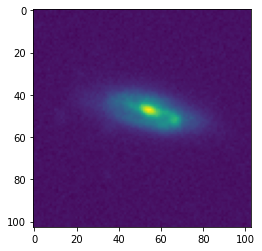

In [10]:
plt.imshow(img)

In [3]:
def extract_int(g_path):
    return int(re.split('(\d+)',g_path.split('/')[-2])[1])

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# StatMorph

## Need Image, Mask, Weight, and PSF

In [4]:
import re

fields = [
    'xc_centroid', 'yc_centroid', 
    'ellipticity_centroid', 'elongation_centroid', 'orientation_centroid',
    'xc_asymmetry', 'yc_asymmetry',
    'ellipticity_asymmetry', 'elongation_asymmetry', 'orientation_asymmetry',
    'rpetro_circ', 'rpetro_ellip', 'rhalf_circ', 'rhalf_ellip',
    'r20', 'r80',
    'gini', 'm20', 'gini_m20_bulge', 'gini_m20_merger',
    'sn_per_pixel', 'concentration', 'asymmetry', 'smoothness',
    'sersic_xc', 'sersic_yc', 'sersic_amplitude', 'sersic_rhalf', 'sersic_n', 'sersic_ellip', 'sersic_theta',
    'sky_mean', 'sky_median', 'sky_sigma',
    'flag', 'flag_sersic']

In [5]:
# Note that there is degeneracy between parameters. 
# Best fit model from scipy.iptimize of the Uncharted TMO is quite different. 
# as [   1.10147711    0.99881915  340.77234402    0.99337089].

def Mantiuk_Seidel(lum, b, c, dl, dh):
    al = (c*dl-1)/dl # contrast compression for shadows
    ah = (c*dh-1)/dh
    lp = np.log10(lum) # L prime

    conditions=[lp <= b-dl,
                (b-dl < lp) * (lp <= b),
                (b < lp) * (lp <= b+dh),
                lp > b+dh]

    functions=[0,
               lambda lp : 1/2*c*(lp-b)/(1-al*(lp-b))+1/2,
               lambda lp : 1/2*c*(lp-b)/(1+ah*(lp-b))+1/2,
               1]

    return np.piecewise(lp, conditions, functions)

params = [[1.68, 0.53, 4.12, 2.46],
          [1.90, 0.88, 2.43, 1.48],
          [1.30, 0.69, 2.53, 7.60],
          [1.38, 0.71, 1.99, 2.10]]

tmo_names = ['BriAda', 'Ashik', 'Retinex', 'log']

In [6]:
# Good galaxies after visual inspection
good_list = glob(basedir+'out1/'+"stat_png/good/*.png")
good_gids=[]
for gg in good_list:
    good_gids.append(gg.split("/")[-1].split("_")[1])
good_gids.sort()
good_fns = [glob(fitsdir+gg+'/*r.fits')[0] for gg in good_gids]

### sort out bad galaxies from the final sample 
1541 VI-selected bad galaxies are excluded. 

In [7]:
# bad
old_r = glob(basedir + 'out1/masks/*.pickle')
old_r.sort()

old_gids = [ll.split('/')[-1].split('_mask')[0] for ll in old_r]
good_gids = [ll.split('/')[-2] for ll in good_fns]

fns_r_final=[]
for fnr in fns_r:
    gid = fnr.split("/")[-2]
    if gid in old_gids and gid not in good_gids:
        continue
    fns_r_final.append(fnr)
        

assert (len(old_gids) - len(good_gids)) == (len(fns_r) - len(fns_r_final))

# Todo

- Reshape / organize data to minimize IO
- TMO as a class. Initialize only once for a set of params. 



In [8]:
from statmorph.utils import image_diagnostics
#import make_figure

def get_fn(gid_string):
    return glob('../../bf_data/Nair_and_Abraham_2010/final/' + gid_string + '/*-r.fits')[0]

def gen_fn_img(morph):
    return out_dir+f'stat_png/final_{morph._gid}_summary.png'

### First pass - for VI

In [ ]:
import logging
#tmo_params = {'a':0.125, 'd':0.975, 'mid_in':0.25, 'mid_out':0.18}
logging.basicConfig(filename='applyting_MS08.log', 
                    format='%(asctime)s - %(message)s', level=logging.INFO)
tmo_name = tmo_names[0]
tmo_params = params[0]

out_dir = basedir+tmo_name+'/'
if not os.path.isdir(out_dir): 
    os.mkdir(out_dir)
    os.mkdir(out_dir+'Morphs')
    os.mkdir(out_dir+'stat_png')
# mkdir
morphs=[]
for i, fn in enumerate(fns_r_final):
    if i < 5000:
        continue
    if i == 9000:
        break
    if i % 500 == 499:
        pickle.dump(morphs, open(out_dir+f"Morphs/final_morphs{i:05d}.pickle", "wb"),
                   protocol=pickle.HIGHEST_PROTOCOL)
        morphs=[]
        print(i)

    img_name = fn.split("/")[-2]
    if dataset=="Nair": 
        gid = img_name
    else:
        gid = int(re.split('(\d+)',img_name)[1])
    hdulist = fits.open(fn)
    # Ensure pixel values are positive
    img = hdulist[0].data
    img -= (img.min() - eps) 

    mask = pickle.load(open(basedir+'out_final'+f"/masks/{img_name}_mask.pickle", 'rb'))

    weight = fits.open(fn.replace(".fits", ".weight.fits"))[0].data
    subtracted = img.copy()
    subtracted[~mask] = np.nan

    #hdr_max = np.percentile(subtracted.ravel(), 99.9) * 1.1 
    subtracted *= 100 # MS08's generic TMs work best for pixels in (1e-2, 1e4)

    #print('min max', subtracted.min(), subtracted.max())
    #tonemapped = tonemapping_operator_generic(subtracted, *tmo_params)
    tonemapped = Mantiuk_Seidel(subtracted, *tmo_params)
    logging.info('subtrated min max: {}, {} --  tonemapped min max: {},{}'.format(subtracted.min(), subtracted.max(), tonemapped.min(), tonemapped.max()))
    morph = statmorph.source_morphology(tonemapped, mask, weightmap=weight, sersic_maxiter=0)[0]

    hdulist.close()
    morph._gid = gid

    statmorph.utils.image_diagnostics.make_figure(morph, nrows=3,
                                  savefig=gen_fn_img(morph),
                                  img_org=None, norm='linear')

    morphs.append(morph)
pickle.dump(morphs, open(out_dir+f"Morphs/final_morphs{i:05d}.pickle", "wb"),
            protocol=pickle.HIGHEST_PROTOCOL)

The meaning of the paramters of a generic TM function (including both MS08 and one from NVIDIA) depends on the range of pixel values. A straightforward scaling in the preprocessing is needed. Do I want to include that as another paramter to the BO loop? probably yes, but,next time.

In [30]:
import logging
#tmo_params = {'a':0.125, 'd':0.975, 'mid_in':0.25, 'mid_out':0.18}
logging.basicConfig(filename='applyting_MS08.log', 
                    format='%(asctime)s - %(message)s', level=logging.INFO)

for i, (tmo_name, tmo_params) in enumerate(zip(tmo_names,params)):
    if i < -3:
        continue
    print(tmo_name, tmo_params)
    out_dir = basedir+tmo_name+'/'
    if not os.path.isdir(out_dir): 
        os.mkdir(out_dir)
        os.mkdir(out_dir+'Morphs')
        os.mkdir(out_dir+'stat_png')
    # mkdir
    morphs=[]
    for i, fn in enumerate(good_fns):
        if i < 0:
            continue
        if i % 500 == 499:
            pickle.dump(morphs, open(out_dir+f"Morphs/final_morphs{i:05d}.pickle", "wb"),
                       protocol=pickle.HIGHEST_PROTOCOL)
            morphs=[]
            print(i)

        img_name = fn.split("/")[-2]
        if dataset=="Nair": 
            gid = img_name
        else:
            gid = int(re.split('(\d+)',img_name)[1])
        hdulist = fits.open(fn)
        # Ensure pixel values are positive
        img = hdulist[0].data
        img -= (img.min() - eps) 
        
        mask = pickle.load(open(basedir+'out1/'+f"/masks/{img_name}_mask.pickle", 'rb'))

        weight = fits.open(fn.replace(".fits", ".weight.fits"))[0].data
        subtracted = img.copy()
        subtracted[~mask] = np.nan
        
        #hdr_max = np.percentile(subtracted.ravel(), 99.9) * 1.1 
        subtracted *= 100 # MS08's generic TMs work best for pixels in (1e-2, 1e4)
        
        #print('min max', subtracted.min(), subtracted.max())
        #tonemapped = tonemapping_operator_generic(subtracted, *tmo_params)
        tonemapped = Mantiuk_Seidel(subtracted, *tmo_params)
        logging.info('subtrated min max: {}, {} --  tonemapped min max: {},{}'.format(subtracted.min(), subtracted.max(), tonemapped.min(), tonemapped.max()))
        morph = statmorph.source_morphology(tonemapped, mask, weightmap=weight, sersic_maxiter=0)[0]

        hdulist.close()
        morph._gid = gid
        
        statmorph.utils.image_diagnostics.make_figure(morph, nrows=3,
                                      savefig=gen_fn_img(morph),
                                      img_org=None, norm='linear')
        
        morphs.append(morph)
    pickle.dump(morphs, open(out_dir+f"Morphs/final_morphs{i:05d}.pickle", "wb"),
                protocol=pickle.HIGHEST_PROTOCOL)

BriAda [1.68, 0.53, 4.12, 2.46]


KeyboardInterrupt: 

In [8]:
all_morphs

['../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs00499.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs00999.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs01499.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs01999.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs02499.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs02999.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs03499.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs03999.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs04499.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs04999.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs05499.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs05999.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs06430.pickle']

In [125]:
out_dir

'../../bf_data/Nair_and_Abraham_2010/BriAda/'

In [16]:
for alm in all_morphs:
    print(alm)
    mps = pickle.load(open(alm,'rb'))
    for morph in mps:
        img_name = morph._gid
        fn = get_fn(img_name)
        # Double Check
            
        hdulist = fits.open(fn)
        img = hdulist[0].data
        img -= (img.min() - eps)
        
        image_diagnostics.make_figure(morph, nrows=3,
                                      savefig=gen_fn_img(morph),
                                      img_org=None)

../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs05499.pickle


/home/hoseung/anaconda3/envs/tm38/lib/python3.8/site-packages/astropy/modeling/functional_models.py:2450: RuntimeWarning: overflow encountered in power
  return amplitude * np.exp(-bn * (z ** (1 / n) - 1))


../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs05999.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs06430.pickle


## Move bad measurements 

In [21]:
import shutil

In [25]:
for alm in all_morphs:
    print(alm)
    mps = pickle.load(open(alm,'rb'))
    for morph in mps:
        if morph.flag ==1:
            fn_img = gen_fn_img(morph)
            try:
                shutil.move(fn_img, fn_img.replace('stat_png/', 'stat_png/bad/'))
            except:
                pass

../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs00499.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs00999.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs01499.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs01999.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs02499.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs02999.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs03499.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs03999.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs04499.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs04999.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs05499.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs05999.pickle
../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs06430.pickle


종종 fit 실패함. 이상한 object가 많으니 충분히 그럴 수 있긴 함. 눈으로 확인.

'모범적인' Sa, Sb, Sc, Sd가 잘 보이도록만 만들면 됨. fore/backgroud object 때문에 fit이 안 되는 경우는 그냥 무시. 얼마나 자주 그러는지만 체크. 


